In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import cv2

In [ ]:
# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [17]:
g_train = {"fake": [], "real": []}
g_test  = {"fake": [], "real": []}

base_dirs = [
    "./dataset/train-20250112T065955Z-001",
    "./dataset/test-20250112T065939Z-001"
]

labels = ["fake", "real"]

for base_dir in base_dirs:
    for label in labels:
        img_dir = os.path.join(base_dir, "train" if "train" in base_dir else "test", label)
        
        files = [os.path.join(img_dir, x) for x in os.listdir(img_dir)]
        
        if "train" in base_dir:
            g_train[label] += files
        else:
            g_test[label] += files
print("Done!")

Done!


In [18]:
# merge all images and labels accordingly
all_images = []
all_labels = []
for label in labels:
    all_images += g_train[label] + g_test[label]
    all_labels += [label]*len(g_train[label]) + [label]*len(g_test[label])

print("Done!")
print(f"Total images: {len(all_images)}")

data = pd.DataFrame({"images": all_images, "labels":all_labels})
display(data)
print("Dataframe created!")

Done!
Total images: 978


images labels
0    ./dataset/train-20250112T065955Z-001/train/fak...   fake
1    ./dataset/train-20250112T065955Z-001/train/fak...   fake
2    ./dataset/train-20250112T065955Z-001/train/fak...   fake
3    ./dataset/train-20250112T065955Z-001/train/fak...   fake
4    ./dataset/train-20250112T065955Z-001/train/fak...   fake
..                                                 ...    ...
973  ./dataset/test-20250112T065939Z-001/test/real/...   real
974  ./dataset/test-20250112T065939Z-001/test/real/...   real
975  ./dataset/test-20250112T065939Z-001/test/real/...   real
976  ./dataset/test-20250112T065939Z-001/test/real/...   real
977  ./dataset/test-20250112T065939Z-001/test/real/...   real

[978 rows x 2 columns]

Dataframe created!


In [19]:
data = data.sample(frac=1, random_state=42)  # Shuffle in place
data.reset_index(drop=True, inplace=True)  # Reset index in place

display(data)
print("Dataframe shuffled!")
print(f"Total images after shuffling: {len(data)}")

images labels
0    ./dataset/test-20250112T065939Z-001/test/fake/...   fake
1    ./dataset/train-20250112T065955Z-001/train/rea...   real
2    ./dataset/test-20250112T065939Z-001/test/fake/...   fake
3    ./dataset/test-20250112T065939Z-001/test/real/...   real
4    ./dataset/train-20250112T065955Z-001/train/fak...   fake
..                                                 ...    ...
973  ./dataset/train-20250112T065955Z-001/train/fak...   fake
974  ./dataset/test-20250112T065939Z-001/test/fake/...   fake
975  ./dataset/train-20250112T065955Z-001/train/rea...   real
976  ./dataset/test-20250112T065939Z-001/test/fake/...   fake
977  ./dataset/train-20250112T065955Z-001/train/fak...   fake

[978 rows x 2 columns]

Dataframe shuffled!
Total images after shuffling: 978


In [20]:
# convert the labels into numeric formate
label_map = {'fake': 0, 'real':1}
data['labels'] = data['labels'].map(label_map)
display(data)
print("Labels converted to numeric format!")
print(f"Unique labels after conversion: {data['labels'].unique()}")
print(data.head())

images  labels
0    ./dataset/test-20250112T065939Z-001/test/fake/...       0
1    ./dataset/train-20250112T065955Z-001/train/rea...       1
2    ./dataset/test-20250112T065939Z-001/test/fake/...       0
3    ./dataset/test-20250112T065939Z-001/test/real/...       1
4    ./dataset/train-20250112T065955Z-001/train/fak...       0
..                                                 ...     ...
973  ./dataset/train-20250112T065955Z-001/train/fak...       0
974  ./dataset/test-20250112T065939Z-001/test/fake/...       0
975  ./dataset/train-20250112T065955Z-001/train/rea...       1
976  ./dataset/test-20250112T065939Z-001/test/fake/...       0
977  ./dataset/train-20250112T065955Z-001/train/fak...       0

[978 rows x 2 columns]

Labels converted to numeric format!
Unique labels after conversion: [0 1]
                                              images  labels
0  ./dataset/test-20250112T065939Z-001/test/fake/...       0
1  ./dataset/train-20250112T065955Z-001/train/rea...       1
2  ./dataset/test-20250112T065939Z-001/test/fake/...       0
3  ./dataset/test-20250112T065939Z-001/test/real/...       1
4  ./dataset/train-20250112T065955Z-001/train/fak...       0


In [21]:
Images = []
Labels = []
max_height = float('-inf')
min_height = float('inf')
max_weidth = float('-inf')
min_weidth = float('inf')
for i in range(len(data)):
    image_path = data['images'][i]
    label = data['labels'][i]
    try:
        img = cv2.imread(image_path)
        # convert BGR  to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is None:
           raise FileNotFoundError("Image not found or unable to read the file.")
        Images.append(img)
        Labels.append(label)
        max_height = max(max_height, img.shape[0])
        min_height = min(min_height, img.shape[0])
        max_weidth = max(max_weidth, img.shape[1])
        min_weidth  = min(min_weidth, img.shape[1])
    except Exception as e:
        print("An unexpected error occurred:", e)

print(f"Max Height: {max_height}")
print(f"Min Height: {min_height}")

print(f"Max Weidth: {max_weidth}")
print(f"Min Weidth: {min_weidth}")

print(f"Total successfully loaded images: {len(Images)}")

libpng warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


Max Height: 7091
Min Height: 135
Max Weidth: 8495
Min Weidth: 183
Total successfully loaded images: 978


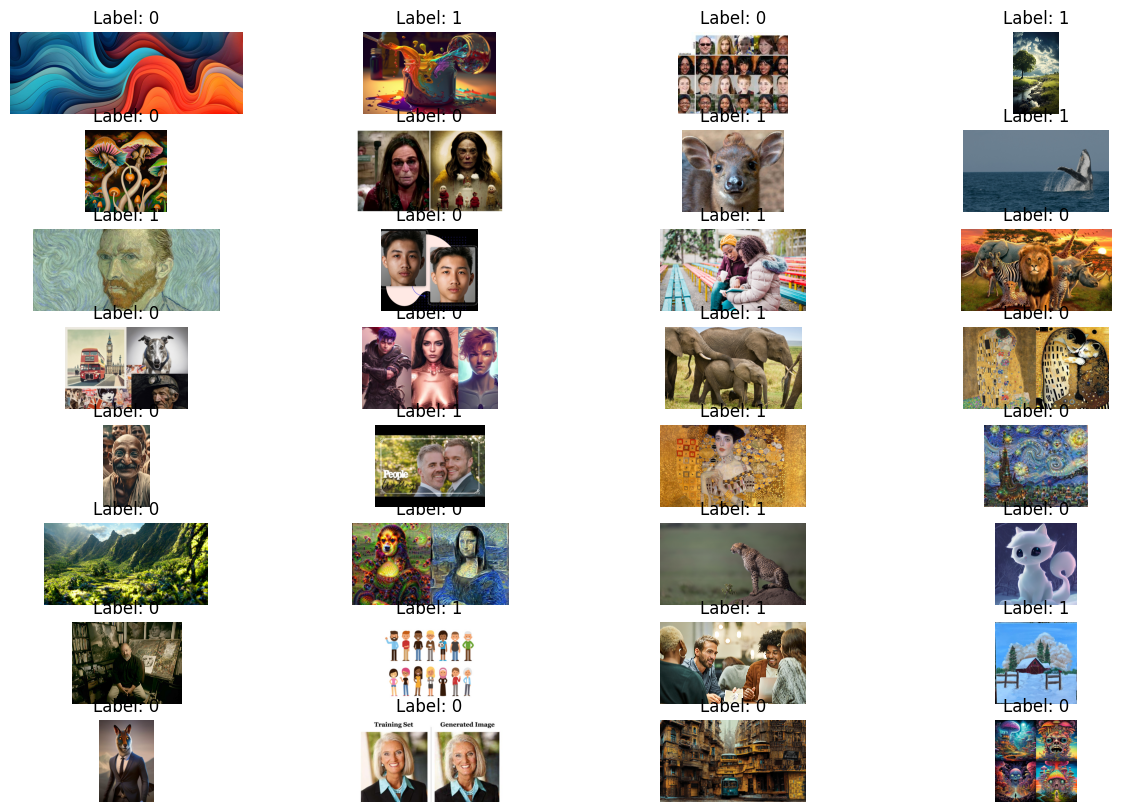

In [22]:
num_imgs = 32
ncols = 4
nrows = (num_imgs + ncols - 1) // ncols
plt.figure(figsize=(15, 10))
for i, img in enumerate(Images[:num_imgs]):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(img)
    plt.title(f"Label: {Labels[i]}")
    plt.axis('off')
plt.show()

Training data shape: 882
Validation data shape: 47
Testing data shape: 49


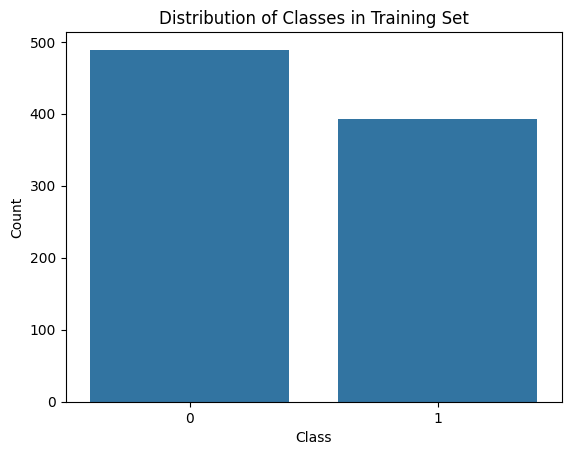

In [23]:
# Stratified splits to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    Images, Labels, test_size=0.05, random_state=42, stratify=Labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.05, random_state=42, stratify=y_train
)

print("Training data shape:", len(X_train))
print("Validation data shape:", len(X_val))
print("Testing data shape:", len(X_test))

sns.countplot(x=np.array(y_train))
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Classes in Training Set")
plt.show()

In [ ]:
# ImageNet normalization stats (required for pretrained ResNet50)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMG_SIZE = 224

# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),  # Slightly larger for random crop
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)  # CRITICAL: ImageNet normalization
])

# Validation/Test transforms (no augmentation, consistent normalization)
val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)  # CRITICAL: Same normalization
])

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = list(images)
        self.labels = torch.tensor(np.array(labels), dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Create datasets with proper transforms
train_dataset = CustomImageDataset(X_train, y_train, transform=train_transform)
val_dataset = CustomImageDataset(X_val, y_val, transform=val_test_transform)
test_dataset = CustomImageDataset(X_test, y_test, transform=val_test_transform)

# DataLoader settings (avoid multiprocessing issues on macOS)
NUM_WORKERS = 0 if sys.platform == "darwin" else 2
PIN_MEMORY = torch.cuda.is_available()

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                            num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# Verify batch shapes and normalization
images, labels = next(iter(train_dataloader))
print(f"Batch image shape: {images.shape}")
print(f"Batch label shape: {labels.shape}")
print(f"Image range: [{images.min():.3f}, {images.max():.3f}] (should be normalized)")
print(f"Sample labels: {labels[:10]}")

In [ ]:
# Load pretrained ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Freeze early layers, unfreeze later layers for fine-tuning
# This allows the model to adapt to our specific task
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last two blocks (layer4 and fc) for fine-tuning
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.layer3.parameters():
    param.requires_grad = True

# Replace classifier head - output logits (not probabilities)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1)  # Output logits, no sigmoid
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.1f}%)")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/kuladeepgompa/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100.0%


In [ ]:
# Calculate class weights for imbalanced data
from collections import Counter
class_counts = Counter(y_train)
total = len(y_train)
class_weights = torch.tensor([
    total / (2.0 * class_counts[0]),  # Weight for class 0 (fake)
    total / (2.0 * class_counts[1])  # Weight for class 1 (real)
]).to(device)
print(f"Class distribution: {class_counts}")
print(f"Class weights: {class_weights}")

# Use BCEWithLogitsLoss with class weights (more stable than BCELoss)
# pos_weight should be weight[1]/weight[0] for binary classification
pos_weight = class_weights[1] / class_weights[0]
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Different learning rates for fine-tuned layers vs new classifier
optimizer = optim.AdamW([
    {'params': [p for n, p in model.named_parameters() if 'layer3' in n or 'layer4' in n], 'lr': 1e-4},
    {'params': [p for n, p in model.named_parameters() if 'fc' in n], 'lr': 1e-3}
], weight_decay=1e-4)

# Learning rate scheduler (Reduce LR on plateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)

# Accuracy function for logits
def binary_accuracy(logits, labels):
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).float()
    labels_float = labels.float().view(-1, 1)
    return (preds == labels_float).sum().item() / labels.size(0)

# Training function with early stopping
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50, save_path="best_resnet50.pth"):
    best_val_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0
    max_patience = 10
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_acc = 0.0, 0.0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)
            
            optimizer.zero_grad()
            logits = model(images)  # Model outputs logits
            loss = criterion(logits, labels)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            train_acc += binary_accuracy(logits, labels)
        
        # Validation phase
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).float().view(-1, 1)
                
                logits = model(images)
                loss = criterion(logits, labels)
                
                val_loss += loss.item()
                val_acc += binary_accuracy(logits, labels)
        
        # Average metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)
        
        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)
        
        # Step scheduler
        scheduler.step(avg_val_loss)
        
        # Save best model based on validation accuracy
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"✓ New best model saved! Val Acc: {best_val_acc:.4f}, Val Loss: {best_val_loss:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= max_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f} | "
              f"LR: {current_lr:.6f} | Best Val Acc: {best_val_acc:.4f}")
    
    return {'train_loss': train_losses, 'train_acc': train_accs, 
            'val_loss': val_losses, 'val_acc': val_accs}

# Train the model
history = train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, 
                epochs=50, save_path="best_resnet50.pth")

Saving the Model with loss0.39272093772888184
Epoch 1/100 | Train Loss: 0.0867, Train Acc: 0.9796 | Val Loss: 0.3927, Val Acc: 0.8511| LR:0.000100 
Epoch 2/100 | Train Loss: 0.0788, Train Acc: 0.9793 | Val Loss: 0.4090, Val Acc: 0.8723| LR:0.000100 
Saving the Model with loss0.35729315876960754
Epoch 3/100 | Train Loss: 0.0756, Train Acc: 0.9793 | Val Loss: 0.3573, Val Acc: 0.8723| LR:0.000100 
Epoch 4/100 | Train Loss: 0.0664, Train Acc: 0.9866 | Val Loss: 0.3675, Val Acc: 0.8511| LR:0.000100 
Epoch 5/100 | Train Loss: 0.0490, Train Acc: 0.9944 | Val Loss: 0.3837, Val Acc: 0.8936| LR:0.000100 
Saving the Model with loss0.2738436460494995
Epoch 6/100 | Train Loss: 0.0470, Train Acc: 0.9933 | Val Loss: 0.2738, Val Acc: 0.9149| LR:0.000100 
Epoch 7/100 | Train Loss: 0.0539, Train Acc: 0.9877 | Val Loss: 0.4091, Val Acc: 0.8298| LR:0.000100 
Epoch 8/100 | Train Loss: 0.0391, Train Acc: 0.9944 | Val Loss: 0.4517, Val Acc: 0.8298| LR:0.000100 
Epoch 9/100 | Train Loss: 0.0467, Train Acc: 0.

In [ ]:
# Load the best model checkpoint
model.load_state_dict(torch.load("best_resnet50.pth"))
model.eval()

# Evaluate on test set
all_preds = []
all_labels = []
all_probs = []

print("Evaluating on test set...")
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels_cpu = labels.numpy()
        
        # Get logits from model
        logits = model(images)
        
        # Convert to probabilities and predictions
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        
        all_preds.extend(preds.flatten())
        all_labels.extend(labels_cpu)
        all_probs.extend(probs.flatten())

# Calculate accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

test_acc = accuracy_score(all_labels, all_preds)
print(f"\n{'='*50}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"{'='*50}\n")

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Fake', 'Real']))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)
print(f"\nTrue Negatives (Fake->Fake): {cm[0,0]}")
print(f"False Positives (Fake->Real): {cm[0,1]}")
print(f"False Negatives (Real->Fake): {cm[1,0]}")
print(f"True Positives (Real->Real): {cm[1,1]}")

Test Accuracy: 0.3673


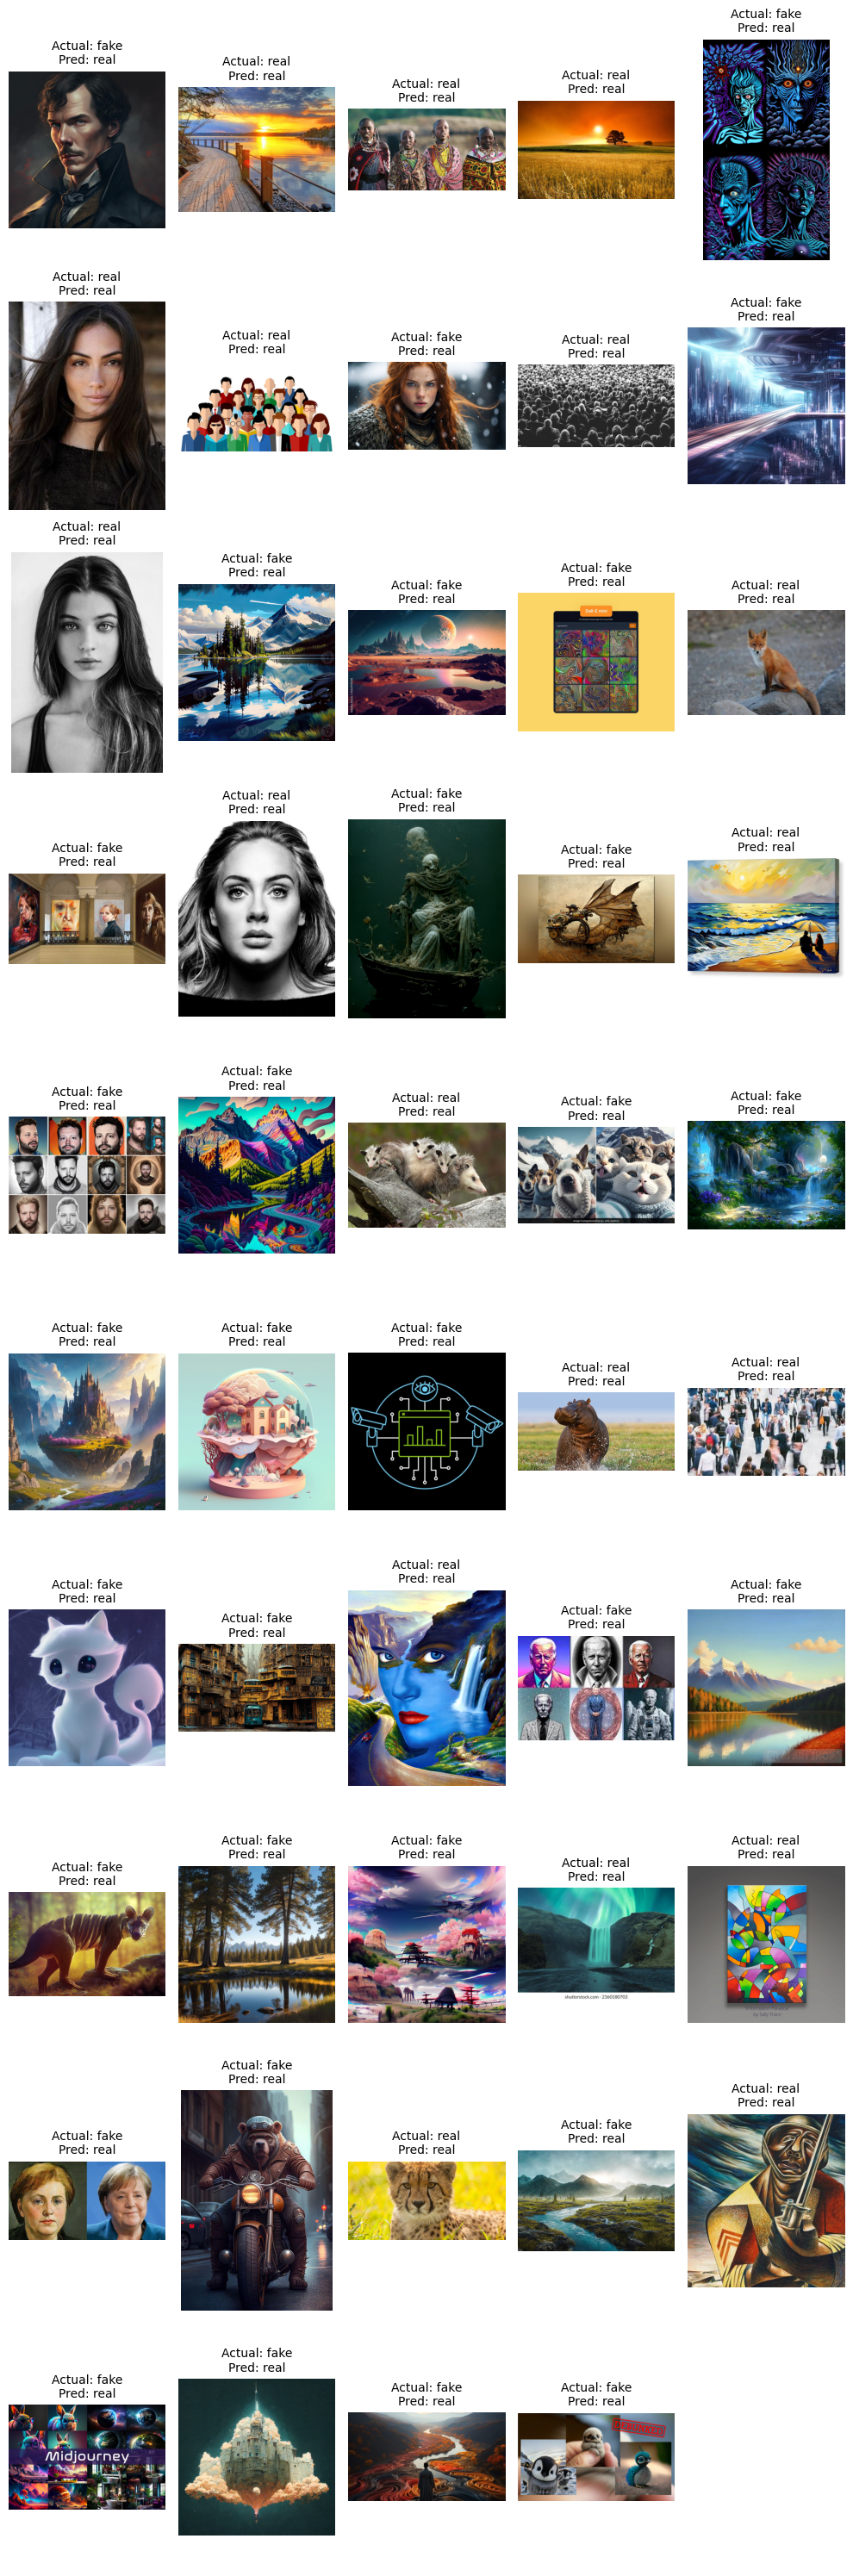

In [ ]:
def plot_test_images(image_list, labels, preds, probs=None, class_names={0: "fake", 1: "real"}, num_images=20):
    """
    Plot test images with predictions.
    image_list: List of test images (NumPy arrays).
    labels: List of actual labels (ints).
    preds: List of predicted labels (ints).
    probs: Optional list of prediction probabilities.
    class_names: Dictionary mapping label indices to class names.
    num_images: Number of images to display.
    """
    num_images = min(num_images, len(image_list))
    ncols = 5
    nrows = int(np.ceil(num_images / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3))
    axes = axes.flatten() if nrows > 1 else [axes] if ncols == 1 else axes
    
    for i in range(num_images):
        img = image_list[i]
        actual_label = class_names[int(labels[i])]
        predicted_label = class_names[int(preds[i])]
        is_correct = int(labels[i]) == int(preds[i])
        
        # Color: green for correct, red for incorrect
        color = "green" if is_correct else "red"
        
        axes[i].imshow(img)
        title = f"Actual: {actual_label}\nPred: {predicted_label}"
        if probs is not None:
            title += f"\nProb: {probs[i]:.2f}"
        axes[i].set_title(title, color=color, fontsize=10, fontweight='bold')
        axes[i].axis("off")
    
    # Hide unused subplots
    for i in range(num_images, len(axes)):
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()

# Plot test results
print("Visualizing test results (Green=Correct, Red=Incorrect):")
plot_test_images(image_list=X_test, labels=all_labels, preds=all_preds, 
                 probs=all_probs, class_names={0: "fake", 1: "real"}, 
                 num_images=min(20, len(X_test)))

In [ ]:
# Plot training history
if 'history' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy plot
    axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
    axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Best validation accuracy: {max(history['val_acc']):.4f}")
    print(f"Final test accuracy: {test_acc:.4f}")


In [ ]:
# ImageNet normalization stats (required for pretrained ResNet50)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMG_SIZE = 224



In [ ]:
# Load pretrained ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Freeze early layers, unfreeze later layers for fine-tuning
# This allows the model to adapt to our specific task
for param in model.parameters():


# Unfreeze the last two blocks (layer4 and fc) for fine-tuning
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.layer3.parameters():
    param.requires_grad = True

# Replace classifier head - output logits (not probabilities)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.BatchNorm1d(1024),
    nn.LeakyReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.LeakyReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.Sigmoid(),
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1)
    )

model = model.to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.1f}%)")



NameError: name 'models' is not defined